# The experimentatl X-ray Photon Correlation Sepectroscopy(XPCS) data
# are fitted with Intermediate Scattering Factor(ISF) using
# lmfit Model (http://lmfit.github.io/lmfit-py/model.html)

In [1]:
import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core.utils as core

from lmfit import minimize, Parameters, Model

import numpy as np
import os, sys
import zipfile

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

:0: FutureWarning: IPython widgets are experimental and may change in the future.


#### Easily switch between interactive and static matplotlib plots

In [2]:
interactive_mode = False

if interactive_mode:
    %matplotlib notebook
else:
    %matplotlib inline

backend = mpl.get_backend()

##  This data provided by Dr. Andrei Fluerasu
L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini, C. Carona and A. Fluerasu ,
"Photon statistics and speckle visibility spectroscopy with partially coherent x-rays"
J. Synchrotron Rad., vol 21, p 1288-1295, 2014.

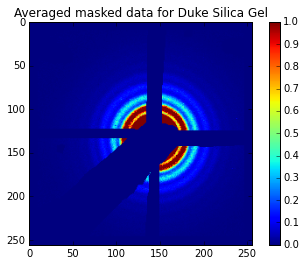

In [3]:
folder = os.path.join(*__file__.split(os.sep)[:-1])

#  Get the data and the mask 
try:
    duke_data = np.load(os.path.join(folder, "duke_data", "duke_data.npy"))
    N_mask = np.load(os.path.join(folder, "duke_data", "N_mask.npy"))
except IOError:
    zipfile.ZipFile(os.path.join(folder, "duke_data.zip")).extractall()
    duke_data = np.load(os.path.join(folder, "duke_data", "duke_data.npy"))
    N_mask = np.load(os.path.join(folder, "duke_data", "N_mask.npy"))

#  get the average image
avg_img = np.average(duke_data, axis=0)

# plot the average image data after masking
plt.figure()
plt.imshow(N_mask*avg_img, vmax=1e0)
plt.title("Averaged masked data for Duke Silica Gel ")
plt.colorbar()
plt.show()

## Create the Rings Mask 
Use the skxray.core.roi module to create Ring ROIs (ROI Mask)¶ (https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/roi.py)

In [12]:
inner_radius = 24  # radius of the first ring
width = 1        # width of each ring
spacing = 0      # no spacing between rings
num_rings = 5    # number of rings
center = (133, 143)   # center of the spckle pattern

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[ 24.,  25.],
       [ 25.,  26.],
       [ 26.,  27.],
       [ 27.,  28.],
       [ 28.,  29.]])

###Convert the edge values of the rings to q ( reciprocal space)

In [13]:
dpix = 0.055  # The physical size of the pixels

lambda_ = 1.5498  # wavelength of the X-rays
Ldet = 2200.   #   # detector to sample distance

two_theta = core.radius_to_twotheta(Ldet, edges*dpix)
q_val = core.twotheta_to_q(two_theta, lambda_)

q_val

array([[ 0.00243251,  0.00253387],
       [ 0.00253387,  0.00263522],
       [ 0.00263522,  0.00273658],
       [ 0.00273658,  0.00283793],
       [ 0.00283793,  0.00293929]])

In [14]:
q_ring = np.mean(q_val, axis=1)
q_ring

array([ 0.00248319,  0.00258455,  0.0026859 ,  0.00278726,  0.00288861])

## Create a labeled array using roi.rings

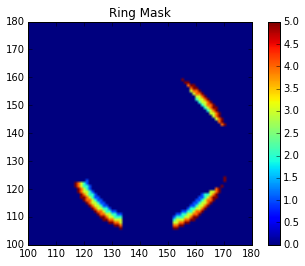

In [15]:
rings = roi.rings(edges, center, avg_img.shape)

mask_data2 = N_mask*duke_data[0:4999]

ring_mask = rings*N_mask

plt.figure()
plt.imshow(ring_mask)
plt.title("Ring Mask")
plt.colorbar()
plt.xlim(100, 180)
plt.ylim(100, 180)
plt.show()

## Find the experimental auto correlation functions

Use the skxray.core.correlation module (https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/correlation.py)

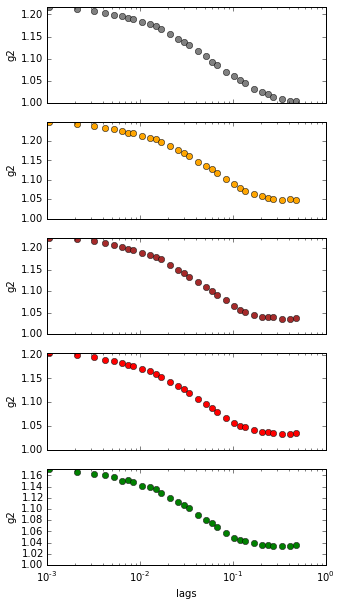

In [16]:
num_levels = 7
num_bufs = 8

g2, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, ring_mask,
                                             mask_data2)

exposuretime=0.001;
deadtime=60e-6;
timeperframe = exposuretime+deadtime
lags = lag_steps*timeperframe

roi_names = ['gray', 'orange', 'brown', 'red', 'green']


fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5,10))
axes[num_rings-1].set_xlabel("lags")
for i, roi_color in zip(range(num_rings), roi_names):
    axes[i].set_ylabel("g2") 
    axes[i].semilogx(lags, g2[:, i], 'o', markerfacecolor=roi_color, markersize=6)
    axes[i].set_ylim(bottom=1, top=np.max(g2[1:, i]))
plt.show()

## Do the fitting

One time correlation data is fitted using the model in skxray.core.correlation module
(auto_corr_scat_factor)
(https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/correlation.py)

In [17]:
mod = Model(corr.auto_corr_scat_factor)

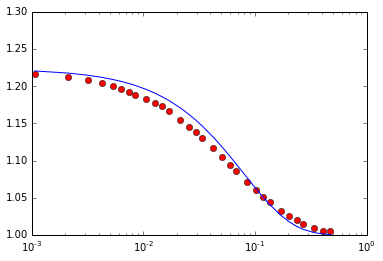

In [18]:
out1 = mod.eval(lags=lags, beta=0.2234, relaxation_rate = 6.2567,  baseline=1.0)

result1 = mod.fit(out1, lags=lags, beta=0.2230, relaxation_rate = 6.2500,  baseline=1.0)
plt.figure()
plt.semilogx(lags, g2[:, 0], 'ro')
plt.semilogx(lags, result1.best_fit, '-b')
plt.ylim(1.0, 1.3)
plt.show()

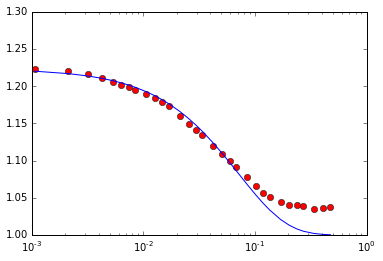

In [19]:
out2 = mod.eval(lags=lags, beta=0.2234, relaxation_rate=6.9879, baseline=1.000)

result2 = mod.fit(out2, lags=lags, beta=0.22456, relaxation_rate=6.98789, beseline=1.00)
plt.figure()
plt.semilogx(lags, g2[:, 2], 'ro')
plt.semilogx(lags, result2.best_fit, '-b')
plt.ylim(1., 1.3)
plt.show()